# Cleaning Modes With Rational Filters

In [5]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [6]:
import matplotlib.pyplot as pl
import numpy as np
import qnm_filter
from gwpy.timeseries import TimeSeries
import copy
from scipy.special import logsumexp

In [7]:
theoretical_values = (68.6, 0.71)

## Data

Download data

In [8]:
home_dir = "./MDC_waveforms/"

In [9]:
H_filename = "H-H1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"
L_filename = "L-L1_NR_INJECTED-1126259448-16_TEOBResumS_GR_q_0.8_chi1_0.1_chi2_0.1_M72_dist452_incl1p59_ra1p68_decm1p27_psi3p93_flow7_nonoise_aligned.gwf"

In [10]:
H_data = TimeSeries.read(home_dir + H_filename, 'H1:NR_INJECTED')
L_data = TimeSeries.read(home_dir + L_filename, 'L1:NR_INJECTED')

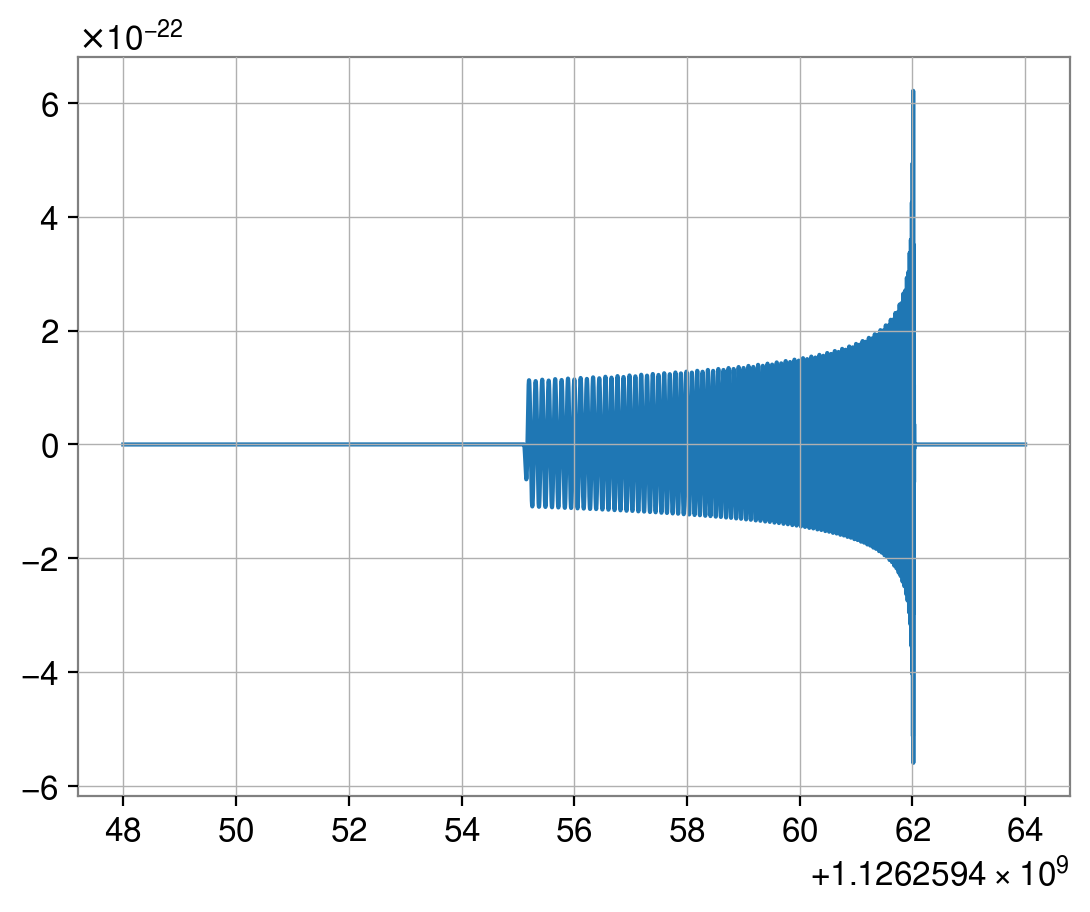

In [11]:
pl.plot(H_data)
# pl.plot(L_data)

In [12]:
H_waveform = qnm_filter.Data(H_data.value, index = H_data.times.value)
L_waveform = qnm_filter.Data(L_data.value, index = L_data.times.value)

In [13]:
peak_time = H_data.times.value[np.argmax(H_waveform)]
SSB_peak_time = peak_time - 0.014685396838313368

In [14]:
SSB_peak_time

1126259461.9987423

## Filter

In [15]:
mass_unit = qnm_filter.Filter.mass_unit(theoretical_values[0])

In [16]:
input = dict(model_list = [(2,2,0),(2,2,1),(2,1,0)], #l, m, n
             # trucation time (geocenter, in second)
             t_init = SSB_peak_time+0*mass_unit, #Calculated from SNR+t_init notebook
             # length of the analysis window (in second)
             window_width = 0.2,
             # sampling rate after conditioning (in Hz)
             srate = 2048,
             # sky localization
             ra = 1.95, dec = -1.27,
             # lower limit of the high-pass filter (in Hz)
             flow = 20)

fit = qnm_filter.Network(**input)

Load data

In [17]:
fit.original_data['H1'] = H_waveform

In [18]:
fit.detector_alignment()
fit.condition_data('original_data', **input, trim = 0.0)
fit.compute_acfs('original_data')

In [19]:
temp_acf = np.full(input['srate'], 0, dtype = np.double)
temp_acf[0] = 1.1*1e-22**2
fit.acfs['H1'] = qnm_filter.Data(temp_acf, index = fit.acfs['H1'].index)
fit.cholesky_decomposition()

In [20]:
fit.first_index()
template = fit.truncate_data(fit.original_data)['H1']

In [21]:
fit.compute_SNR(0, template, 'H1', optimal=True)

13.68167643909268

In [22]:
delta_mass = 1.0
delta_chi = 0.05
massspace = np.arange(34, 140, delta_mass)
chispace = np.arange(0.0, 0.95, delta_chi)
mass_grid, chi_grid = np.meshgrid(massspace, chispace)

In [23]:
fit.first_index()
likelihood_data, evidence = qnm_filter.parallel_compute(fit, massspace, chispace, num_cpu = 9, **input)
credible_region = qnm_filter.find_credible_region(likelihood_data)

/home/neil/anaconda3/envs/ringdown/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [24]:
credible_region = qnm_filter.find_credible_region(likelihood_data, target_probability=0.9)

In [25]:
projected_mass, projected_chi = qnm_filter.project_to_1d(likelihood_data, delta_mass, delta_chi)

In [26]:
average_mass = np.dot(projected_mass, massspace)
average_chi = np.dot(projected_chi, chispace)
MAP_idx = np.argmax(likelihood_data)
MAP_value = (mass_grid.reshape(-1)[MAP_idx], chi_grid.reshape(-1)[MAP_idx])

In [27]:
filters_str = '+'.join([''.join(str(i) for i in j) for j in input['model_list']])
time_str = str(np.round((input['t_init'] - SSB_peak_time)/mass_unit, 2))

In [28]:
def epsilon_calc(mass_err, chi_err, mass_theoretical, chi_theoretical):
    temp0 = chi_err**2
    temp1 = (mass_err/mass_theoretical)**2
    return np.sqrt(temp0+temp1)

In [29]:
average_epsilon = epsilon_calc(average_mass - theoretical_values[0], average_chi - theoretical_values[1],
                   theoretical_values[0], theoretical_values[1])
MAP_epsilon = epsilon_calc(MAP_value[0] - theoretical_values[0], MAP_value[1] - theoretical_values[1],
                   theoretical_values[0], theoretical_values[1])

Text(105, 0.1, 'ln(evidence) = 4.01')

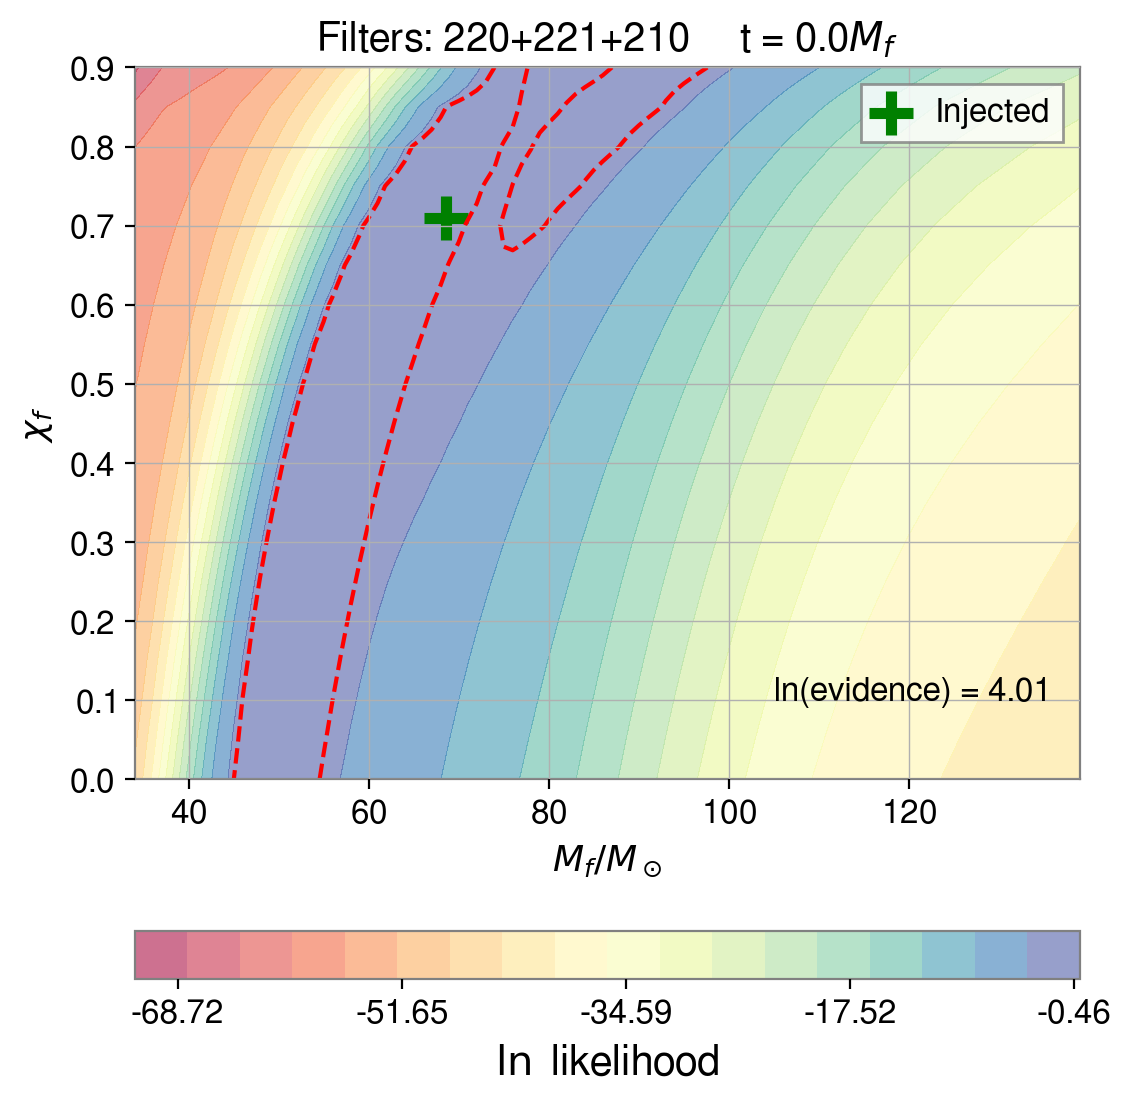

In [30]:
pl.rc('figure', figsize=(6.1, 6.6))
fig, ax = pl.subplots()
contours = ax.contourf(mass_grid, chi_grid, likelihood_data, 20, cmap='Spectral',
                       origin='lower', alpha=0.6, linestyles='--')
dotted = ax.contour(mass_grid, chi_grid, likelihood_data, [credible_region], colors = 'red', \
                   linestyles ='--')
ax.scatter(x=theoretical_values[0], y=theoretical_values[1], s=255, marker='+', 
           c='g', linewidths=4, label='Injected')
# ax.scatter(x=average_mass, y=average_chi, s=255, marker='+', 
#            c='r', linewidths=4, label='weighted average')
# ax.scatter(x=MAP_value[0], y=MAP_value[1], s=255, marker='+', 
#            c='y', linewidths=4, label='MAP')


# coloarbar
cbar=fig.colorbar(contours, orientation="horizontal", 
                  pad=0.15, format='%3.2f')
cbar.set_label(r'$\ln$ likelihood', fontsize=15)
cbar.set_ticks(np.linspace(np.min(likelihood_data), np.max(likelihood_data), 5))

pl.xlabel(r'$M_f/M_\odot$', fontsize=13)
pl.ylabel(r'$\chi_f$', fontsize=13)
pl.legend()
ax.set_title("Filters: " + filters_str + "     t = " + time_str + r'$M_f$')
ax.text(105, 0.1, 'ln(evidence) = %.2f' % (logsumexp(likelihood_data)))
# ax.text(118, 0.1, '$\epsilon_{MAP} = %.2f$' '\n' '$\epsilon_{avg} = %.2f$' % (MAP_epsilon, average_epsilon))